## Watershed Exercise - Bain & Company AAG

### EDA

###### First we will perform EDA on the data to get as much information as we can, detect any outliers or anomalies, and get a full understanding of the struture of the data.

In [196]:
# Importing the necessary packages for this exercise
import numpy as np # linear algebra
import pandas as pd # data processing
from datetime import timedelta

# System
import os
import warnings
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Algorithms that we might use
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [164]:
# Exploring flux CSV

# Loading the Datasets
flux = pd.read_csv('C:\\Users\\fmfor\\Documents\\Bain\\flux.csv')

In [136]:
# Printing top rows to test if we have the right type of data in our object
flux.head()

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859


In [5]:
# Understanding the data types of the different columns
flux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180480 entries, 0 to 4180479
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   date        object 
 1   basin_id    int64  
 2   flux        float64
 3   precip      float64
 4   temp_max    float64
 5   gauge_name  object 
 6   lat         float64
 7   lon         float64
 8   mean_elev   float64
 9   area_km2    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 318.9+ MB


In [165]:
# Let´s transform date column from object to date type
flux["date"] =  pd.to_datetime(flux["date"], format="%Y/%m/%d")

In [7]:
# Let´s understand if we have missing valueswithin the data
flux.isnull().sum()

date             0
basin_id         0
flux             0
precip        5443
temp_max      5443
gauge_name       0
lat              0
lon              0
mean_elev        0
area_km2         0
dtype: int64

#### Given the missing values we will plot both precip and temp max over time.

#### Hypothesis: Data may be missing because of future values - We will try to understand the dates of the data to make assumptions as to in wich point of time we satnd with this challenge.

In [166]:
# Creting a smaller datasets to test our hypothesis 

test_hyp = flux[(flux['basin_id']==1001001) & ((flux['date'] > '2000/01/01') & (flux['date'] < '2021/12/31'))]
test_hyp_temp = flux[(flux['basin_id']==1020002) & ((flux['date'] > '2000/01/01') & (flux['date'] < '2021/12/31'))]

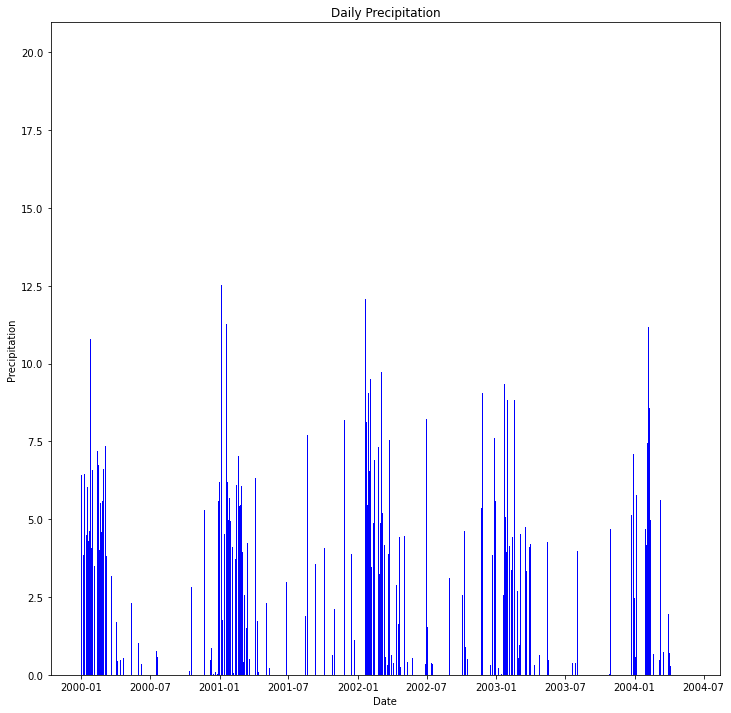

In [16]:
# Let´s plot Precip varible for one of the stations

# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis
ax.bar(test_hyp.date.values,
       test_hyp['precip'],
       color='blue')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Precipitation",
       title="Daily Precipitation")

plt.show()

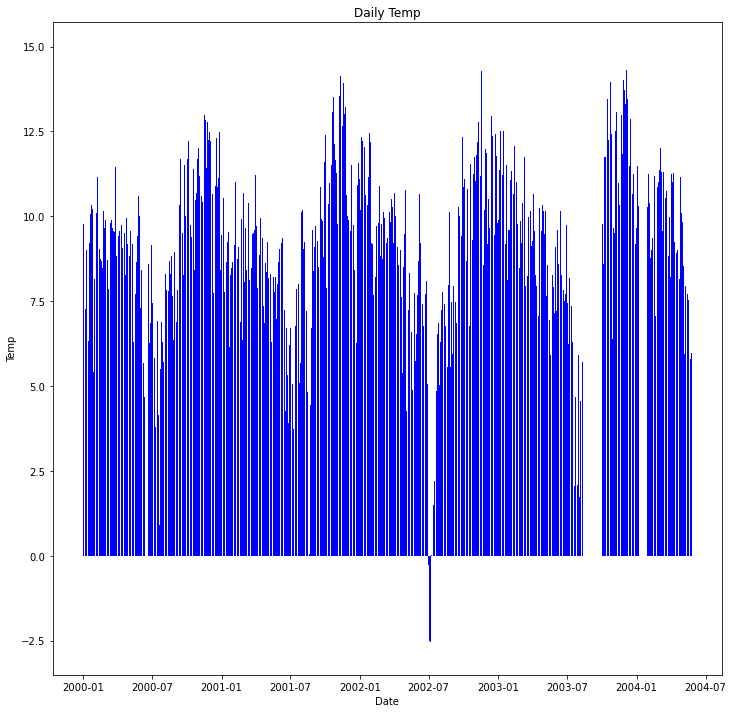

In [11]:
# Let´s plot Precip varible for one of the stations

# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis
ax.bar(test_hyp.date.values,
       test_hyp['temp_max'],
       color='blue')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Temp",
       title="Daily Temp")

plt.show()

##### Given the different dates we can see that we don´t have the same timeline for every basin
##### Finnally we see that seasonality will take an important role on this exercice 

In [7]:
# Printing a statistical summary of the data to view some basic statistical details
flux.describe()

,basin_id,flux,precip,temp_max,lat,lon,mean_elev,area_km2
count,4.180480e+06,4.180480e+06,4.175037e+06,4.175037e+06,4.180480e+06,4.180480e+06,4.180480e+06,4.180480e+06
mean,7.179757e+06,5.253340e+01,2.947445e+00,1.365728e+01,-3.569572e+01,-7.129595e+01,1.760129e+03,2.404876e+03
std,3.180965e+06,1.676027e+02,8.766749e+00,6.615037e+00,8.047659e+00,1.254339e+00,1.382121e+03,4.322051e+03
min,1.001001e+06,0.000000e+00,0.000000e+00,-1.160359e+01,-5.494690e+01,-7.366670e+01,1.181229e+02,1.789123e+01
25%,4.558001e+06,8.680000e-01,0.000000e+00,9.162867e+00,-3.915000e+01,-7.231670e+01,5.847012e+02,3.761001e+02
50%,7.350003e+06,5.171000e+00,0.000000e+00,1.321396e+01,-3.588420e+01,-7.137190e+01,1.195311e+03,8.205541e+02
75%,9.416001e+06,2.990000e+01,6.422626e-01,1.805745e+01,-3.126560e+01,-7.050670e+01,3.048161e+03,2.461610e+03
max,1.293000e+07,1.580500e+04,2.132120e+02,4.081117e+01,-1.784280e+01,-6.763920e+01,4.910152e+03,5.224367e+04


In [167]:
# Les´t first exclude NULL values and filter for flux, precip and temp_max so that we can properly visualize them

flux_hist = flux[['flux', 'precip', 'temp_max']]
flux_hist = flux_hist.dropna(axis=0)

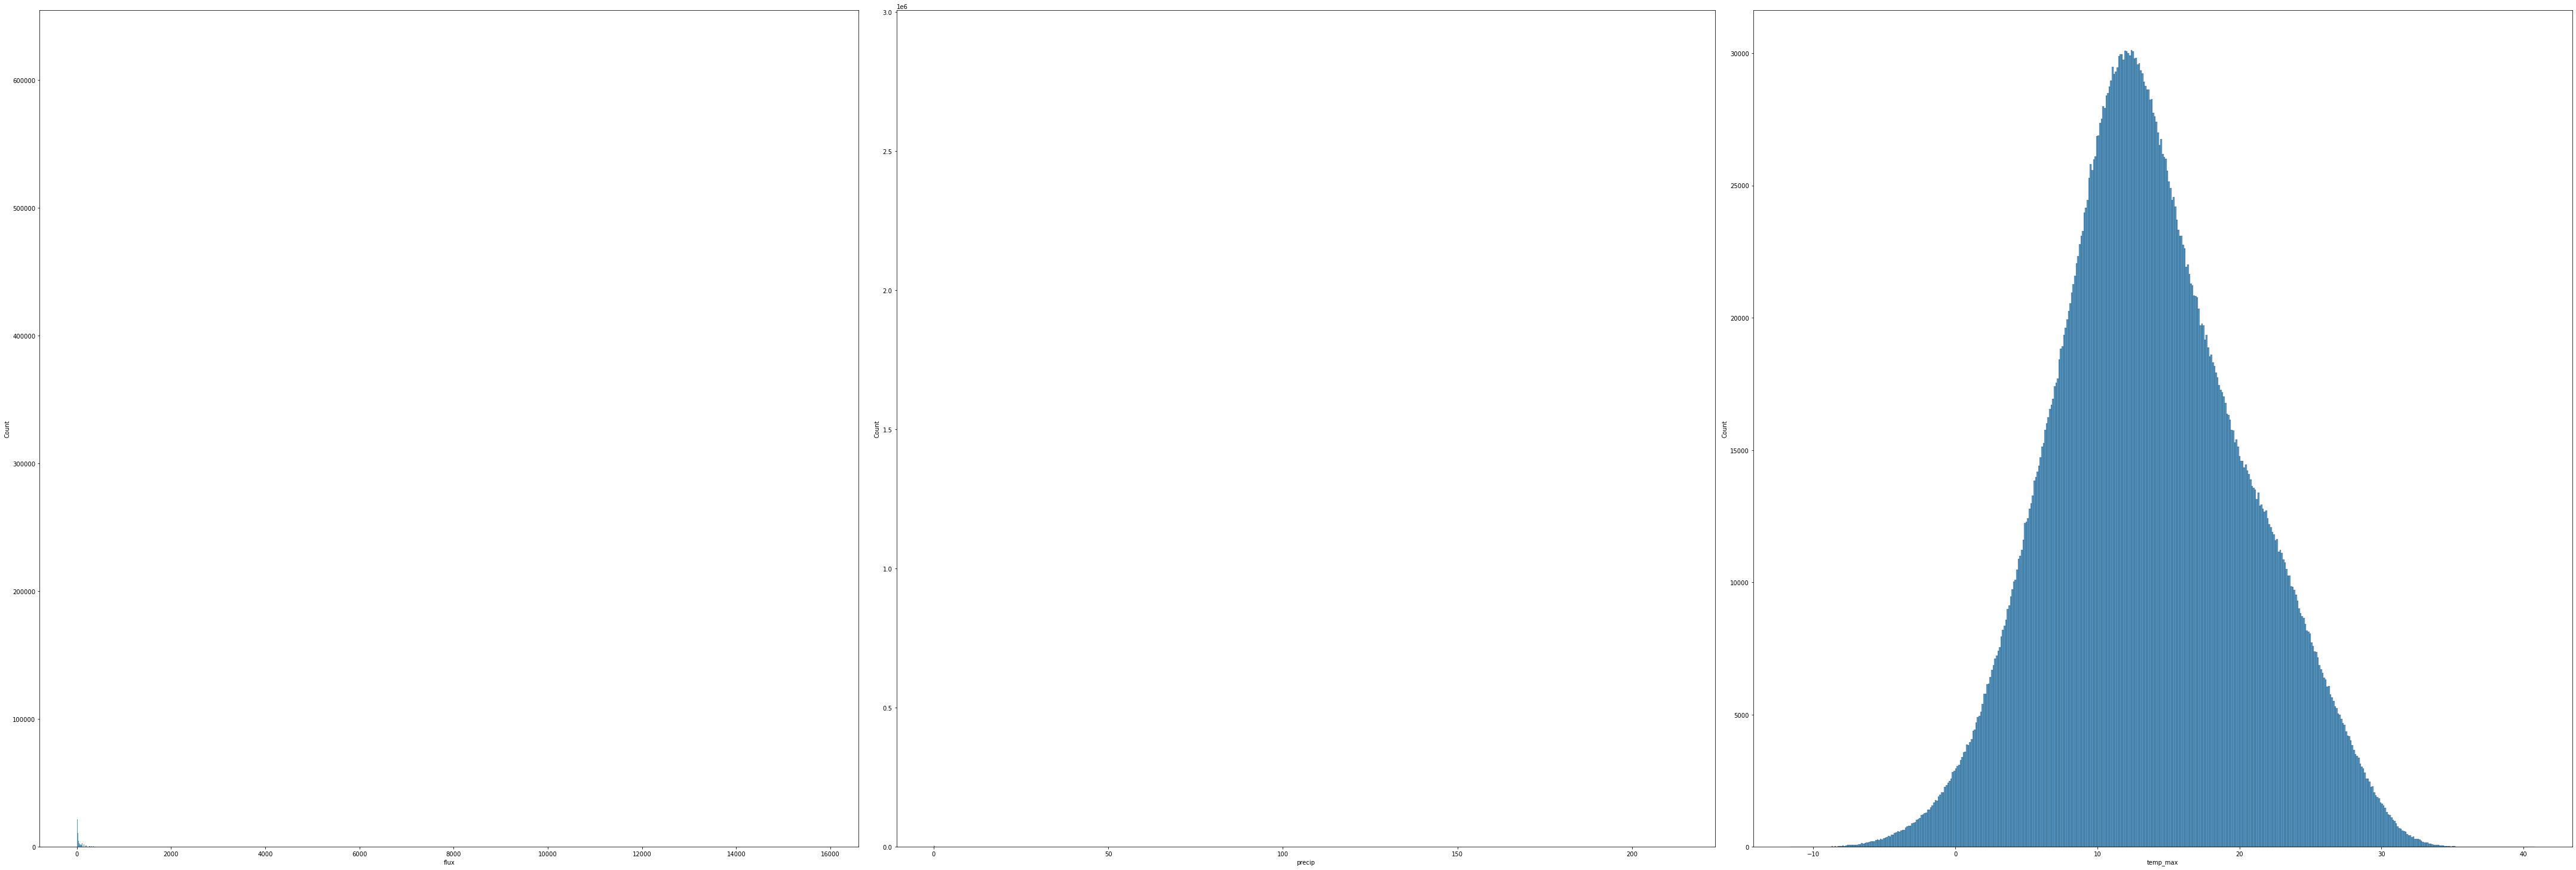

In [12]:
# Visualizing histograms for important numeric variables

cols = 3
rows = 3
num_cols = flux_hist.select_dtypes(exclude='object').columns
fig = plt.figure( figsize=(cols*20, rows*20))
for i, col in enumerate(num_cols):
    
    ax=fig.add_subplot(rows,cols,i+1)
    
    sns.histplot(x = flux_hist[col], ax = ax)
    
fig.tight_layout()  
plt.show()

#### Given the results on flux and precip histograms it´s better to create a box plot to better visualize outliers
#### Temp_max follows a normal distribution

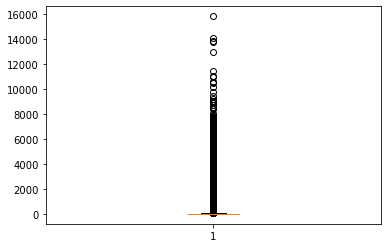

In [7]:
# Box plot for flux

bp = plt.boxplot(flux_hist['flux'])
plt.show()

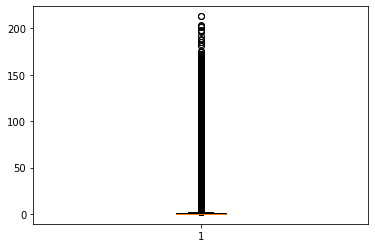

In [8]:
# Box plot for precip

bp = plt.boxplot(flux_hist['precip'])
plt.show()

### Plot flux, temperature and precipitations
#### Let´s create a couple of user defined functions for us to plot easily our variables

In [20]:
# Creating a function that plot a time series of a specific variable (flux, temp, precip) from a station

def plot_one_timeserie(cod_station, variable, min_date='1950-01-01', max_date='2030-01-01'):

    timeseries = flux[flux['basin_id'] == cod_station].set_index('date')[variable]

    range_date = timeseries.loc[min_date:max_date]

    ax = sns.lineplot(data = range_date)
    ax.set(title = f"{flux[flux.basin_id == cod_station]['basin_id'].tolist()[0]}")

    plt.show()

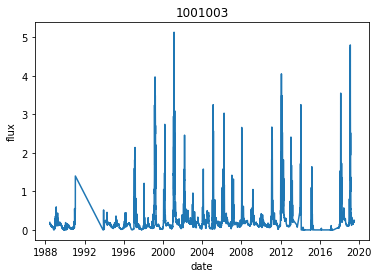

In [23]:
# Testing our UDF with flux and one basin_id

plot_one_timeserie(1001003, 'flux', '1980-01-01', '2021-01-01')

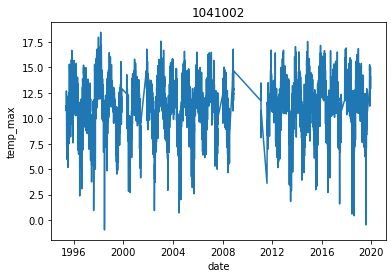

In [26]:
# Testing our UDF with temp_max and one basin_id

plot_one_timeserie(1041002, 'temp_max', '1980-01-01', '2021-01-01')

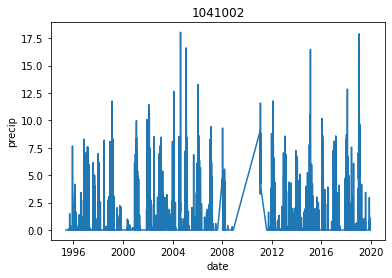

In [27]:
# Testing our UDF with precip and one basin_id

plot_one_timeserie(1041002, 'precip', '1980-01-01', '2021-01-01')

In [32]:
# Now let´s write a function that plots the 3 variables at the same time

def plot_three_timeseries(cod_station, min_date='1950-01-01', max_date='2030-01-01'):

    timeseries_2 = flux[flux.basin_id == cod_station].set_index('date')

    range_date = timeseries_2.loc[min_date:max_date][['flux', 'precip', 'temp_max']]
    
    normalized = (range_date - range_date.mean()) / range_date.std()

    ax = sns.lineplot(data = normalized)
    ax.set(title = f"{timeseries_2['basin_id'].tolist()[0]}")

    plt.show()

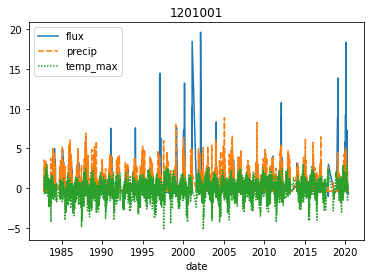

In [35]:
# Testing our UDF

plot_three_timeseries(1201001, '1980-01-01', '2021-01-01')

### Extreme variable

#### Let´s create the extreme flag for flux, temp and precip

#### We will:

###### 1. Determine that a data point is considered extreme when the value is over the 95 percentile of the distribution for that specific season
###### 2. Determine this by month, not by seasons. Given that during witner for example there might be different extreme temperatures. An extreme temperature during december might be considered normal in january or febuary for example.

In [168]:
# Let´s crete a new dataframe without null values

df = flux.dropna(axis=0)

In [40]:
# Let´s determine the extremes for the different variables

threshhold_flux = df.flux.quantile(0.95) # 95th percentile
print(threshhold_flux) # Any data point above the threshold is considered extreme

262.0


#### But we need a threshold for every month of the year

In [169]:
# Let´s first create a month column we will needed later also for our predictive model
df['month'] = df['date'].dt.month

In [170]:
# Let´s create a threshold for every month of the year

range_t = []

for i in range(1,13): #(12 months)
    df_group = df.loc[df['month'] == i]
    threshhold_flux = df_group.flux.quantile(0.95) # 95th percentile
    range_t.append(threshhold_flux)

In [171]:
# Let´s create a dataframe by month and flux threshold 

t_df['threshold'] = pd.DataFrame(range_t)
t_df['month'] = range(1,13)

In [172]:
# Let´s tag those dates with extreme flux in the original dataset

df = pd.merge(df, t_df, on ='month', how ='inner')

### Creating flux_extreme variable



In [173]:
# Adding flux extreme column to our dataframe
df['flux_extreme'] = np.where(
    df['flux'] >= df['threshold'], 1, np.where(
    df['flux'] >  df['threshold'], 0, 0)) 

In [174]:
# Checking head flux extreme values

check_flux = df.query("flux_extreme == 1")
check_flux.head()

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,month,0,threshold,flux_extreme
115771,1983-01-01,5410002,227.0,0.000000,16.240876,Rio Aconcagua En Chacabuquito,-32.8503,-70.5094,3177.583522,2113.422512,1,184.0,184.0,1
115772,1983-01-02,5410002,210.0,0.003817,13.744670,Rio Aconcagua En Chacabuquito,-32.8503,-70.5094,3177.583522,2113.422512,1,184.0,184.0,1
115773,1983-01-03,5410002,193.0,0.000000,14.747746,Rio Aconcagua En Chacabuquito,-32.8503,-70.5094,3177.583522,2113.422512,1,184.0,184.0,1
115774,1983-01-04,5410002,195.0,0.000000,16.973446,Rio Aconcagua En Chacabuquito,-32.8503,-70.5094,3177.583522,2113.422512,1,184.0,184.0,1
115775,1983-01-05,5410002,218.0,0.000000,16.357621,Rio Aconcagua En Chacabuquito,-32.8503,-70.5094,3177.583522,2113.422512,1,184.0,184.0,1


### Both temp extreme and precip extreme can be calculated the same way. Not done here for time constrains.

## Modeling - ML models to predict extreme flux

#### We can´t use temp_max and precip variables because we don´t know the future (and assuming we don´t have an accurate prediction for the next day for example). But we can use the previous day data to understand if our model can accurately predict extreme flux

In [178]:
# Let´s start by shifting to previous day data for precip and temp

freq = 'D' # 'D' for days

d=df.set_index([df.date, 'basin_id'])['precip'].to_dict()
df['precip_previous']=(df.set_index([df['date'] - pd.Timedelta(1, unit=freq), 'basin_id']).
                       index.to_series().map(d).reset_index(drop=True))

print(df.head())

        date  basin_id   flux  precip   temp_max                 gauge_name  \
0 1980-01-01   1001001  0.579     0.0  10.685653  Rio Caquena En Nacimiento   
1 1980-01-02   1001001  0.543     0.0  11.470960  Rio Caquena En Nacimiento   
2 1980-01-03   1001001  0.482     0.0  11.947457  Rio Caquena En Nacimiento   
3 1980-01-04   1001001  0.459     0.0  12.424489  Rio Caquena En Nacimiento   
4 1980-01-05   1001001  0.436     0.0  12.649203  Rio Caquena En Nacimiento   

       lat      lon    mean_elev   area_km2  month      0  threshold  \
0 -18.0769 -69.1961  4842.449328  49.711859      1  184.0      184.0   
1 -18.0769 -69.1961  4842.449328  49.711859      1  184.0      184.0   
2 -18.0769 -69.1961  4842.449328  49.711859      1  184.0      184.0   
3 -18.0769 -69.1961  4842.449328  49.711859      1  184.0      184.0   
4 -18.0769 -69.1961  4842.449328  49.711859      1  184.0      184.0   

   flux_extreme  precip_previous  
0             0              NaN  
1             0       

In [181]:
# ...and the same with temp

d2=df.set_index([df.date, 'basin_id'])['temp_max'].to_dict()
df['temp_previous']=(df.set_index([df['date'] - pd.Timedelta(1, unit=freq), 'basin_id']).
                       index.to_series().map(d2).reset_index(drop=True))

In [186]:
# ...and finnaly previous day flux 

d3=df.set_index([df.date, 'basin_id'])['flux'].to_dict()
df['flux_previous']=(df.set_index([df['date'] - pd.Timedelta(1, unit=freq), 'basin_id']).
                       index.to_series().map(d3).reset_index(drop=True))

In [187]:
# Testing with some examples that our shift is working

df.tail()

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,month,0,threshold,flux_extreme,precip_previous,temp_previous,year,day,flux_previous
4175032,2019-12-27,12930001,0.692,6.280501e-02,15.381777,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,12,233.9886,233.9886,0,0.758884,15.073987,2019,4,0.705
4175033,2019-12-28,12930001,0.803,0.000000e+00,14.580901,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,12,233.9886,233.9886,0,0.062805,15.381777,2019,5,0.692
4175034,2019-12-29,12930001,0.784,0.000000e+00,13.754139,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,12,233.9886,233.9886,0,0.000000,14.580901,2019,6,0.803
4175035,2019-12-30,12930001,0.724,1.001864e+00,13.820327,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,12,233.9886,233.9886,0,0.000000,13.754139,2019,0,0.784
4175036,2019-12-31,12930001,0.646,9.100000e-15,13.128466,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,12,233.9886,233.9886,0,1.001864,13.820327,2019,1,0.724


In [183]:
# Creating two more date variables (year and day) we can test if they 
# are significant with the feature importance of the model later

df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.weekday

In [188]:
# Let´s sort our dataframe by date

df = df.sort_values(by='date')

In [199]:
# Train/test split

# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
train_size=0.8

# filtering for the columns that we think are important

X = df[['basin_id', "month", "day", "year", "precip_previous", "temp_previous", "flux_previous"]].copy()
y = df['flux_extreme']

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, Y_train, y_rem = train_test_split(X,y, train_size=0.8, random_state=384)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_val, X_test, Y_val, Y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=384)

print(X_train.shape), print(Y_train.shape)
print(X_val.shape), print(Y_val.shape)
print(X_test.shape), print(Y_test.shape)

(3340029, 7)
(3340029,)
(417504, 7)
(417504,)
(417504, 7)
(417504,)


(None, None)

### Let´s start with LGBM

#### The process for all algorithms is:

##### 1. Fit a basic model
##### 2. Understand feature importance
##### 3. Creating a randomized Serch CV
##### 4. Predictions with best parameters

In [200]:
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(y_true, y_pred):
    smape_val = smape(y_true, y_pred)
    return 'SMAPE', smape_val, False

In [201]:
# basic model to understand metrics
first_model = lgb.LGBMRegressor(random_state=384).fit(X_train, Y_train, 
                                                      eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

TRAIN SMAPE: 190.65645705472002
VALID SMAPE: 190.59534130394985


In [202]:
# Feature importance of basic model
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns

    # SKLEARN API
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=50)

           feature  split       gain
6    flux_previous    780  81.056315
1            month    516  16.700836
4  precip_previous    413   1.007420
0         basin_id    838   0.804786
5    temp_previous    252   0.358602
3             year    128   0.047047
2              day     73   0.024994


In [203]:
# Parameters to search best params
lgbm_params = {
"num_leaves":[10,20,31], # Default 31
"max_depth":[-1, 20, 30], # Default -1
"learning_rate":[0.1, 0.05], # Default 0.1
"n_estimators":[10000,15000], # Default 100
"min_split_gain":[0.0, 2,5], # Default 0
"min_child_samples":[10, 20, 30], # Default 20
"colsample_bytree":[0.5, 0.8, 1.0], # Default 1
"reg_alpha":[0.0, 0.5, 1], # Default 0
"reg_lambda":[0.0, 0.5, 1] # Default 0
}

model = lgb.LGBMRegressor(random_state=384)

In [ ]:
# Creating a randomized Serch CV
rsearch = RandomizedSearchCV(model, lgbm_params, random_state=384, scoring=smape, verbose = True, n_jobs = -1).fit( X_train, Y_train )

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
# Checking the best parameters
rsearch.best_params_

In [ ]:
# Tunning the model and fitting
model_tuned2 = lgb.LGBMRegressor(**rsearch.best_params_, random_state=384, metric = "custom")

model_tuned2.fit(
    X_train, Y_train,
    eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)],
    eval_set = [(X_train, Y_train), (X_val, Y_val)],
    eval_names = ["Train", "Valid"],
    early_stopping_rounds= 10000, verbose = 500
)
print("Best Iteration:", model_tuned2.booster_.best_iteration)

#### * The randomized search takes 2+ hour to run in my local computer. 
##### Similar technique is used for other algorithms like random forest, xgbost etc...
##### Because of time thw rest of the challenge is left for discussion